(mmm_causal_ladder)=
# MMMs and Pearl's ladder of causal inference

In this notebook, we will explore [Judea Pearl's](https://en.wikipedia.org/wiki/Judea_Pearl) causal ladder and how it can be applied to solve business problems with Media Mix Models (MMMs). We will assume familiarity with the basics of MMMs in order to focus on causal inference.

## What is Pearl's causal ladder?

Pearl's causal ladder outlines 3 successively more sophisticated levels of causal reasoning:

1. **Prediction / Forecasting / Association:** With the first step on the ladder, we could use a model to predict future sales based on past data. This does not involve causal reasoning, just prediction.

2. **Intervention:** The second step on the ladder involves using a model to predict the future effect of an intervention. It is similar to step 1 in that it involves prediction/forecasting, but it is different in that we consider a potential intervention that will have effects in the future.

3. **Counterfactuals:** The third and final step on the ladder could use a to estimate how the world _would_ have been different if we had taken a different action in the past. This is clearly different from the first two steps in that it is retrospective. It is also the most sophisticated level of causal reasoning - it involves learning about the world from historical data, but then imagining how the world _could_ have been different in a counterfactual scenario.

![Causal Ladder](../../_static/causal_ladder.png)

The image of Pearl's causal ladder appears in the book "[The Book of Why](https://en.wikipedia.org/wiki/The_Book_of_Why)" by Judea Pearl and Dana Mackenzie. The book is a great introduction to causal inference.

## The do-operator

The do-operator is a key concept in Pearl's causal inference framework and is required for causal reasoning on steps 2 or 3 of the causal ladder. It is used to denote interventions in a system. If we think about our modeling efforts as describing a Bayesian structural causal model, then the do-operator is used to denote the effect of changing a variable in the model. Any incoming causal links to that node are severed, and the node is set to the value specified by the do-operator.

:::{seealso}
For practical examples of the do-operator in action, the following resources are useful:
* [Causal analysis with PyMC: Answering "What If?" with the new do operator](https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/)
* [Interventional distributions and graph mutation with the do-operator](https://www.pymc.io/projects/examples/en/latest/causal_inference/interventional_distribution.html)
:::

## How does this help us solve business problems?

Now we've recapped the causal ladder, let's consider how it can help us solve business problems, specifically with MMMs. Let's look at a few example use cases and see what level of the causal ladder they correspond to:

* **Predicting future sales:** A very common use-case of MMM's is to make forecasts of our outcome variable (e.g. sales). This can be particularly useful ingredient in demand forecasting for example. Once we've trained an MMM on historical data we can use the MMM to predict future sales (out of sample prediction) based on past sales, marketing spend, and other predictor variables. This would correspond to step 1 on the causal ladder - we are forecasting into the future but not considering any changes to our marketing strategy. See our docs {ref}`mmm_budget_allocation_example` for a worked example.

* **Optimizing existing marketing spend:** A more sophisticated use-case of MMM's is to use the model to predict the effect of different marketing strategies (see our docs {ref}`mmm_time_slice_cross_validation`). For example, we could use it to predict the effect of various different changes to media spend. We could then predict the expected sales under these scenarios and pick a scenario which maximises sales or profit, for example. This corresponds to step 2 on the causal ladder - intervention. This is a more sophisticated level of causal reasoning, as it involves prediction, but in the presence of an altered marketing strategies (i.e. interventions). 

* **Planning an increase in marketing spend:** Let's say our business wants to gain more market share and has decided to increase marketing spend by 20% over the next quarter. You are tasked with proposing a number of different future media spend strategies that you think will cause the largest increase in sales. This corresponds to step 2 on the causal ladder - intervention. We are predicting the effect of an intervention (increasing media spend) on sales.

* **Evaluating the impact of a previous increase in marketing spend:** Let's say our business increased TV spend by 20% over the last quarter and we want to know what impact this had on sales. We can answer this question by comparing what _actually_ happened, to what we think _would have happened_ under some alternative imagined counterfactual scenario such as not increasing TV spend by 20%. Importantly, this counterfactual reasoning is _retrospective_, but it uses the knowledge we have learnt from all observations so far. This corresponds to step 3 on the causal ladder - counterfactual inference. We are learning from historical data, but then imagining how the world _could_ have been different in a counterfactual scenario. So this involves retrospective causal reasoning.

## Notebook setup

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from IPython.display import Image

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
seed: int = sum(map(ord, "ladder"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Generate synthetic data

Now we'll generate some synthetic data to use in the rest of the notebook. In short, we will consider a relatively simple situation where:
* We have two media channels: $x_1$ and $x_2$
* We consider the effects of time in terms of a linear trend and a seasonal effect

We can draw our causal DAG like this:

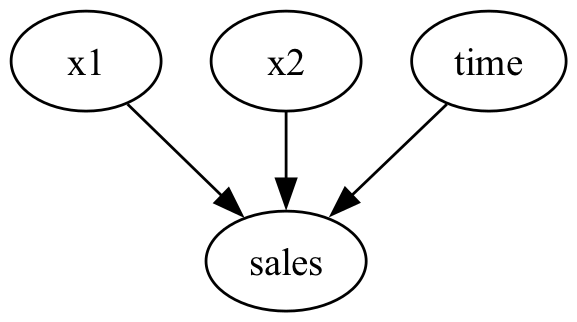

In [4]:
g = gr.Digraph(format="png", graph_attr={"dpi": "200"})
g.node(name="x1", label="x1")
g.node(name="x2", label="x2")
g.node(name="t", label="time")
g.node(name="y", label="sales")
g.edge(tail_name="x1", head_name="y")
g.edge(tail_name="x2", head_name="y")
g.edge(tail_name="t", head_name="y")
g.render(filename="dag")
Image(filename="dag.png")

In the code below we will generate some synthetic data with the general structure described above. Our dataset is going to include a marketing campaign where we elevate the spending on one media channel for a period of time. This is going to be used later on when we come to examine Step 3 where we will evaluate the impact of this campaign. 

As a slight twist is that because we are using simulated data, we are in the privileged position of knowing the true causal relationships in the data. This is not the case in the real world, where we have to infer these relationships from the data. So we'll first generate a _counterfactual_ scenario (where we didn not run the campaign) and then generate the _actual_ scenario (where we did run the campaign). This allows us to compare our _estimated_ causal impact of the campaign with the _true_ causal impact of the campaign. But more on this when we reach Step 3 of the causal ladder.

Let's generate some synthetic data - more specifically some predictors such as media spend, intercept, seasonality, and trend.

In [5]:
# Code adapted from https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html


def generate_counterfactual_dataset(params, rng):
    """Generate a synthetic dataset.

    For the counterfactual scenario of no advertising campaign.
    """
    # date range
    min_date = pd.to_datetime("2019-04-01")
    max_date = pd.to_datetime("2021-09-01")

    df = pd.DataFrame(
        data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
    ).assign(
        year=lambda x: x["date_week"].dt.year,
        month=lambda x: x["date_week"].dt.month,
        dayofyear=lambda x: x["date_week"].dt.dayofyear,
        t=lambda x: range(x.shape[0]),
    )

    n_rows = df.shape[0]

    # media data
    x1 = rng.uniform(low=0.0, high=1.0, size=n_rows)
    df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

    x2 = rng.uniform(low=0.0, high=1.0, size=n_rows)
    df["x2"] = np.where(x2 > 0.8, x2, 0)

    # Trend and seasonality calculations
    df["intercept"] = 2.0

    df["trend"] = (np.linspace(start=0.0, stop=50, num=n_rows) + 10) ** (1 / 4) - 1

    df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
    df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
    df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

    df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n_rows)

    df = forward_pass(df, params)
    return df

Now we'll write a function to forward simulate the response (sales), given these predictor variables. The functions below simply calculate a weighted sum of the predictor variables, after having passed the media channels through our trust adstock and saturation functions.

In [6]:
def apply_transformations(df, channel, alpha, lam):
    """Apply geometric adstock and saturation transformations."""
    adstocked = geometric_adstock(
        x=df[channel].to_numpy(), alpha=alpha, l_max=8, normalize=True
    ).eval()

    saturated = logistic_saturation(x=adstocked, lam=lam).eval()
    return saturated


def forward_pass(df_in, params):
    """Run predictor variables through the forward pass of the model.

    Given a dataframe with spend data columns `x1` and `x2`, run this through the
    transformations and return the response variable `y`.
    """
    df = df_in.copy()

    # Apply transformations to channels and calculate y
    df["y"] = params["amplitude"] * (
        df["intercept"]
        + df["trend"]
        + df["seasonality"]
        + sum(
            params["beta"][i]
            * apply_transformations(
                df, params["channels"][i], params["alpha"][i], params["lam"][i]
            )
            for i in range(len(params["channels"]))
        )
        + df["epsilon"]
    )

    return df

Now let's use those functions to generate synthetic data that represents what happens in our simulated world under a 'business as usual' (or counterfactual) scenario of no media campaign.

In [7]:
params = {
    "channels": ["x1", "x2"],
    "amplitude": 1.0,
    "beta": [3.0, 2.0],
    "lam": [4.0, 3.0],
    "alpha": [0.4, 0.2],
}

df_counterfactual = generate_counterfactual_dataset(params, rng)

Finally, let's create a close copy of this data, but one where we conducted an intervention. That is, a marketing campaign where we increased media spend in channel 1 by 40% for Q1 of 2021. This `df_actual` data will represent what actually happened in our world. The `df_counterfactual` data will represent what _would_ have happened if we had not conducted the intervention, and this will be used when we encounter Step 3 of the causal ladder.

In [8]:
def simulate_intervention(df: pd.DataFrame, intervention_dates) -> pd.DataFrame:
    """Simulate an intervention.

    This function will generate the 'actual' dataset. Based on the counterfactual
    dataset, apply the intervention on the specified date and return the actual dataset.
    """
    df = df.copy()
    # increase x1 by 40% in for date_week between intervention_dates
    df.loc[
        (df["date_week"] >= intervention_dates[0])
        & (df["date_week"] < intervention_dates[1]),
        "x1",
    ] *= 1.40
    # compute the outcome variable
    df = forward_pass(df, params)
    return df


intervention_dates = (pd.to_datetime("2021-01-01"), pd.to_datetime("2021-03-31"))
df_actual = simulate_intervention(df_counterfactual, intervention_dates)

Let's visialize the dataset:

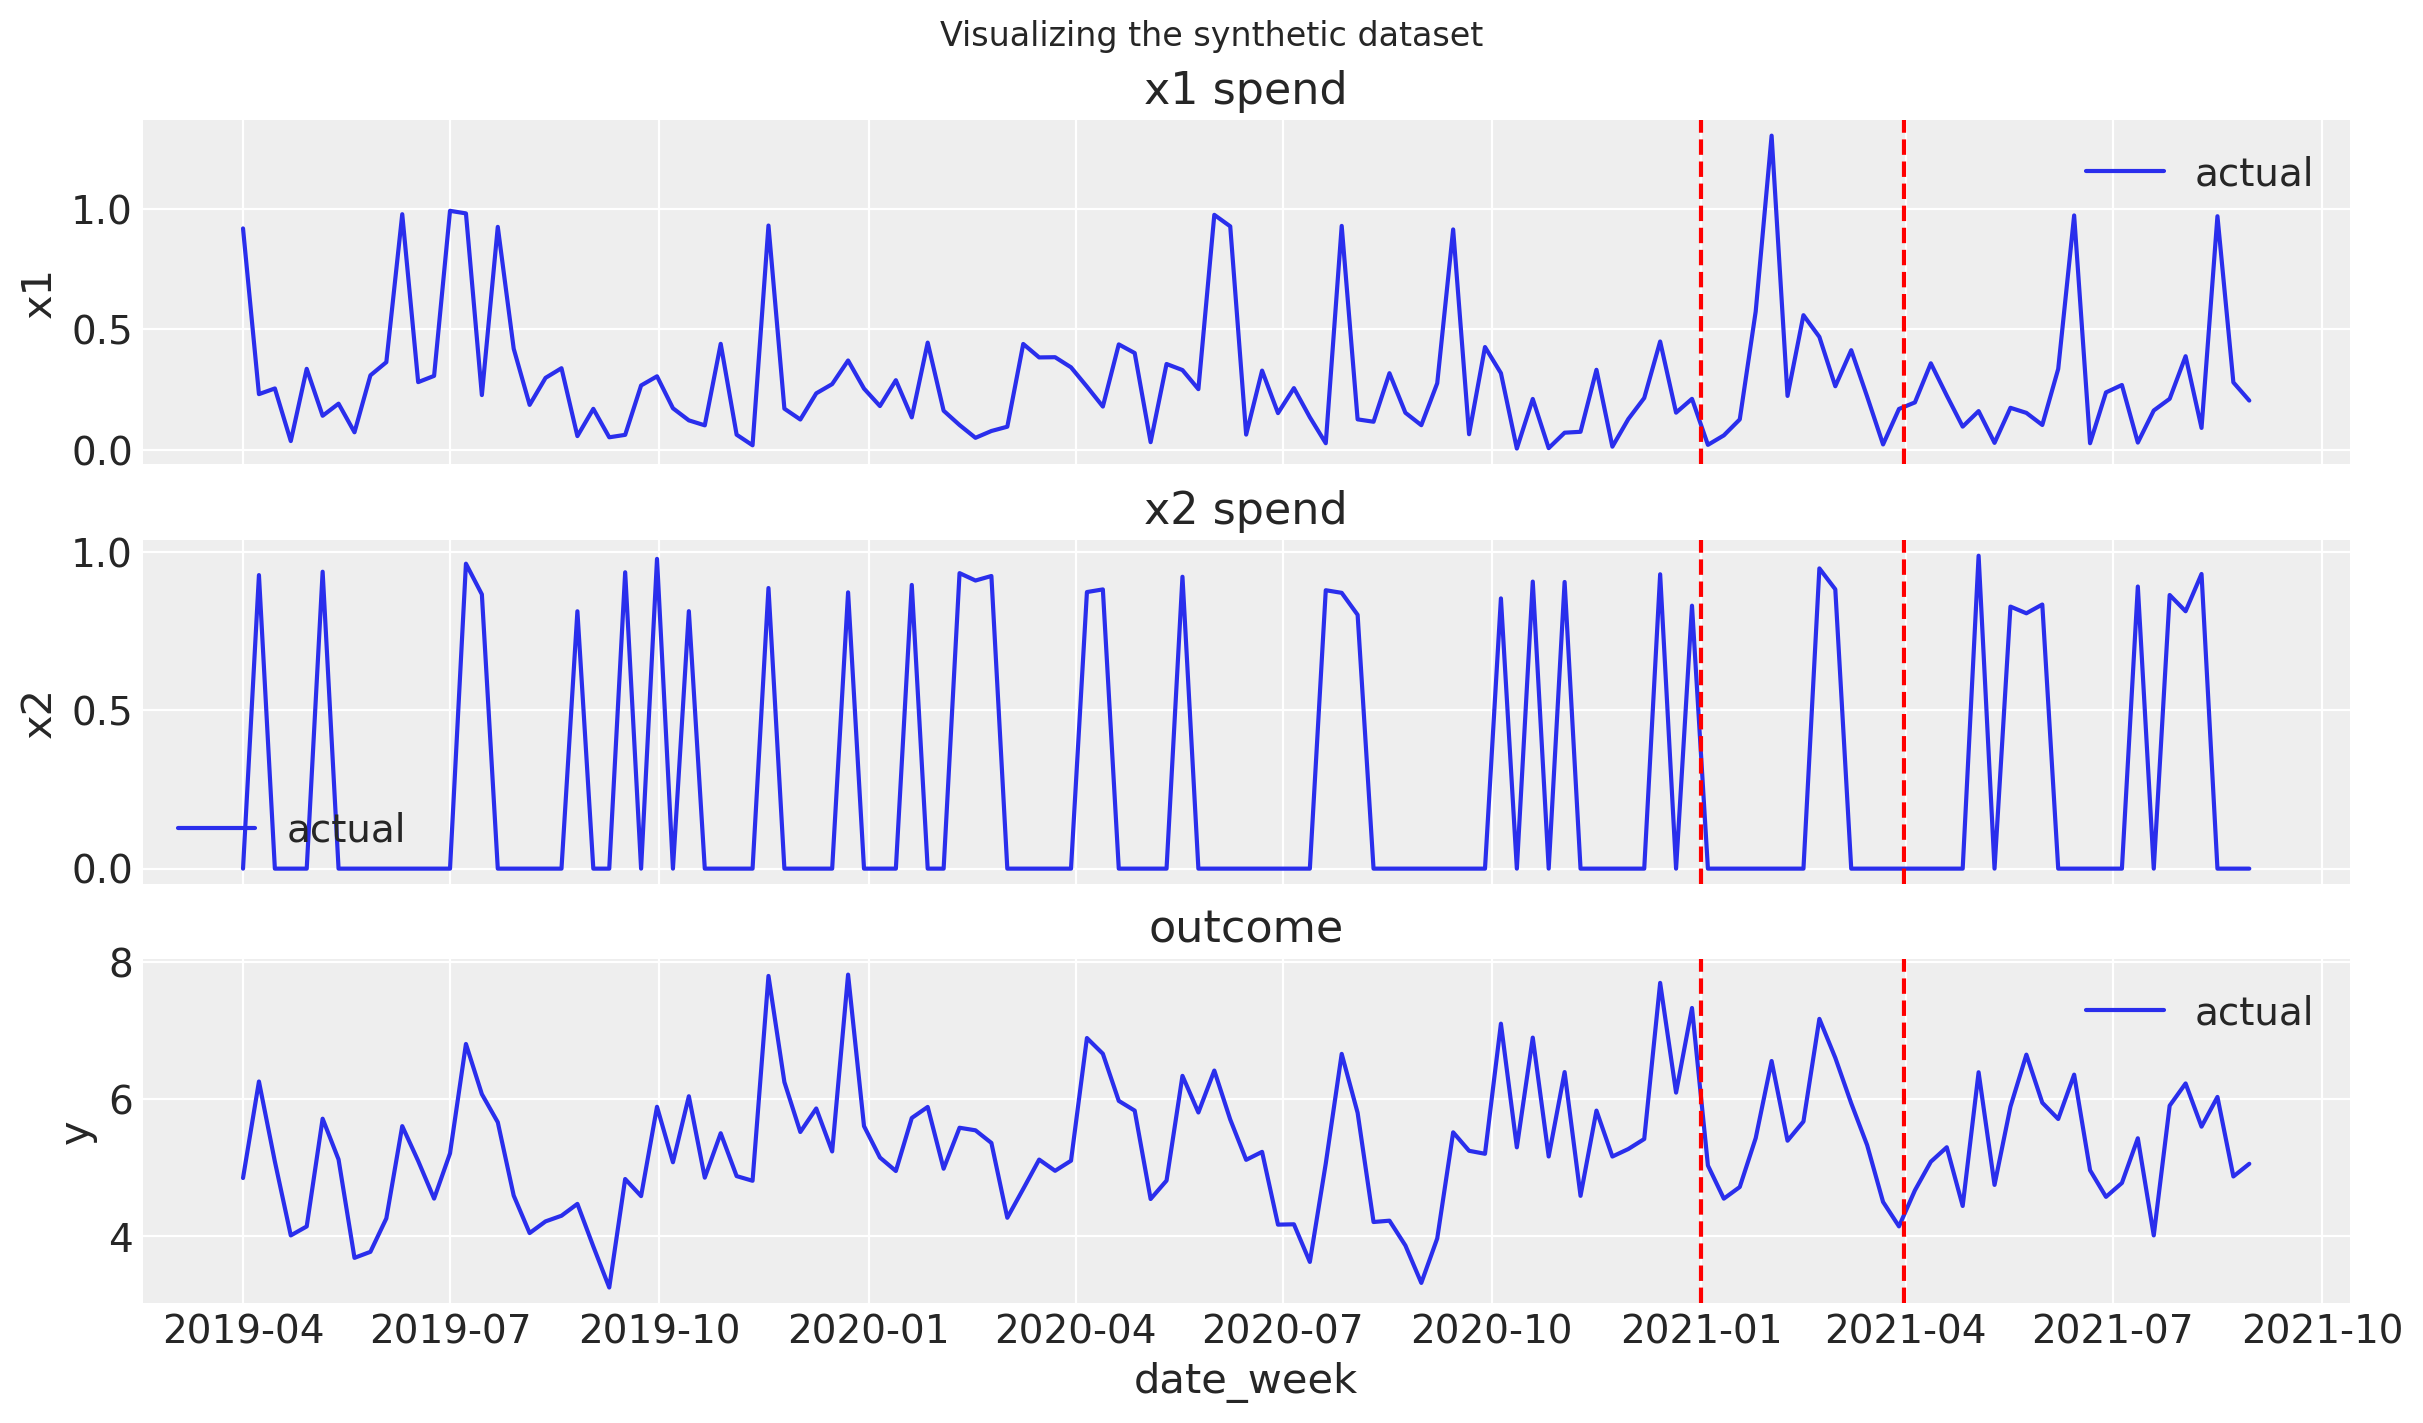

In [9]:
def plot_intervention_dates(intervention_dates, ax):
    dates = [pd.to_datetime(date) for date in intervention_dates]
    for date in dates:
        ax.axvline(
            x=date,
            color="red",
            linestyle="--",
            label="intervention date",
        )


fig, ax = plt.subplots(3, 1, sharex=True)

sns.lineplot(x="date_week", y="x1", data=df_actual, label="actual", ax=ax[0])
ax[0].set(title="x1 spend")

sns.lineplot(x="date_week", y="x2", data=df_actual, label="actual", ax=ax[1])
ax[1].set(title="x2 spend")

sns.lineplot(x="date_week", y="y", data=df_actual, label="actual", ax=ax[2])
ax[2].set(title="outcome")

for axis in ax:
    plot_intervention_dates(intervention_dates, axis)

plt.suptitle("Visualizing the synthetic dataset");

This plot shows our (normalised) media spends (top two panels) and the resulting sales (bottom panel). Our dataset also involves a period (between dashed red lines) where we ran a marketing campaign that increased our media spend by 40%.

## Build an MMM and fit to data

As part of our regular MMM workflow, we'll build an MMM object and fit it to our synthetic data.

In [10]:
mmm = MMM(
    date_column="date_week",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=["x1", "x2"],
    control_columns=["t"],
    yearly_seasonality=2,
)

In [11]:
# prepare data for model
X = df_counterfactual.drop("y", axis=1)
y = df_counterfactual["y"]

# fit
mmm.fit(X=X, y=y, target_accept=0.85, chains=4, random_seed=rng)
# generate posterior predictive samples
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [y]


Output()

Before starting our procedure for counterfactual inference, let's first confirm that the MMM is doing a reasonable job of accounting for the data. Below is a plot of the posterior predictive distribution for the sales (shaded regions) and the actual sales (black line).

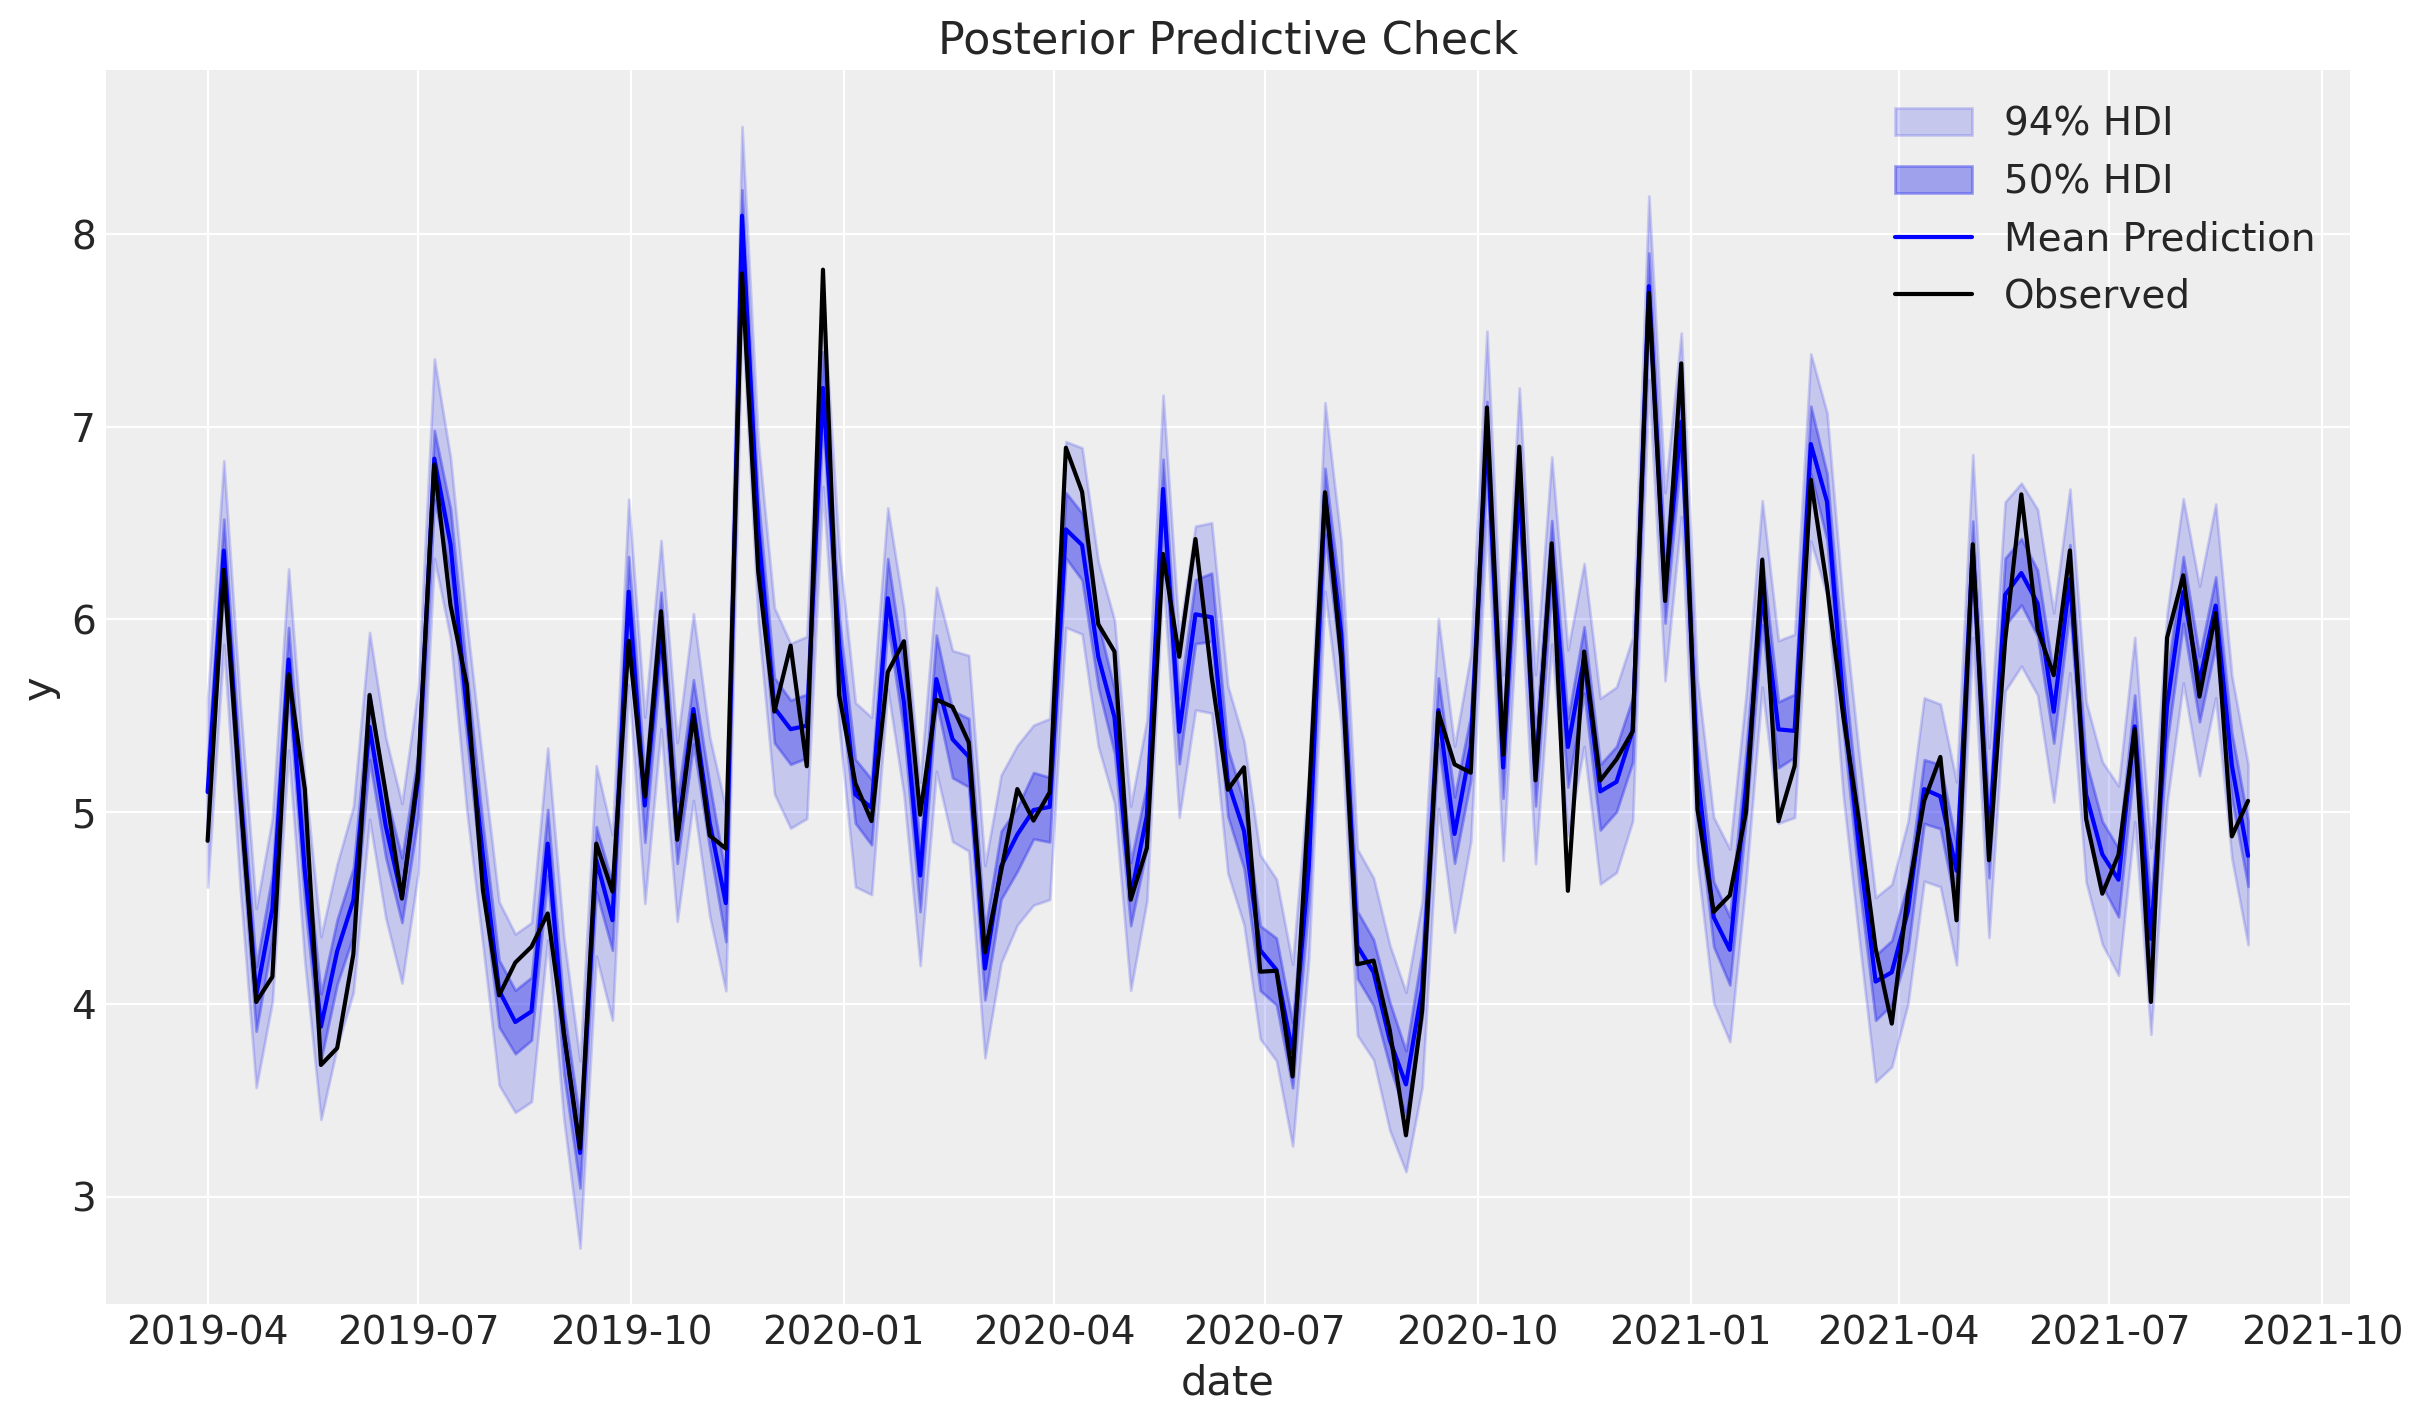

In [12]:
mmm.plot_posterior_predictive(original_scale=True);

The model seems to be doing a good job of capturing the data so we can proceed.

## Level 1 - Association and Prediction

On Level 1 of the ladder, we can do at least 2 things:

1. Explore the model fit results - gain insights about the relationship between media spend and sales. Not note, at this point, even if our MMM represents a causal DAG that captures what we believe to be reasonable causal relationships, we are still only operating on the level of prediction and association.

2. Use the model to predict future sales. This is a common use-case of MMMs and corresponds to step 1 on the causal ladder. Let's dive in to this in more detail.

In order to predict future sales, we need to specify future values of our predictor variables. For simplicity, we will assume that our media spend will remain constant at the last observed value. We will then use the MMM to predict future sales.

In [13]:
# Generate scenario for forecasting

n_new_periods = 20

X_forecast = pd.DataFrame(
    {
        "date_week": pd.date_range(
            start=X["date_week"].max(), periods=1 + n_new_periods, freq="W-MON"
        )[1:]
    }
).assign(
    # assume avarage spends into the future
    x1=X["x1"].mean(),
    x2=X["x2"].mean(),
    # other features
    t=lambda df: range(len(X), len(X) + n_new_periods),
)

X_forecast.head()

,date_week,x1,x2,t
0,2021-09-06,0.280493,0.244675,127
1,2021-09-13,0.280493,0.244675,128
2,2021-09-20,0.280493,0.244675,129
3,2021-09-27,0.280493,0.244675,130
4,2021-10-04,0.280493,0.244675,131


Now we have a 'prediction scenario' we can use our MMM to predict future sales, based upon what it has learnt from historical data.

In [14]:
y_forecast = mmm.sample_posterior_predictive(
    X_pred=X_forecast, extend_idata=False, include_last_observations=True
)

Sampling: [y]


Output()

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_77783/2666701474.py:17: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  X_out_of_sample["date_week"].dt.to_pydatetime(),


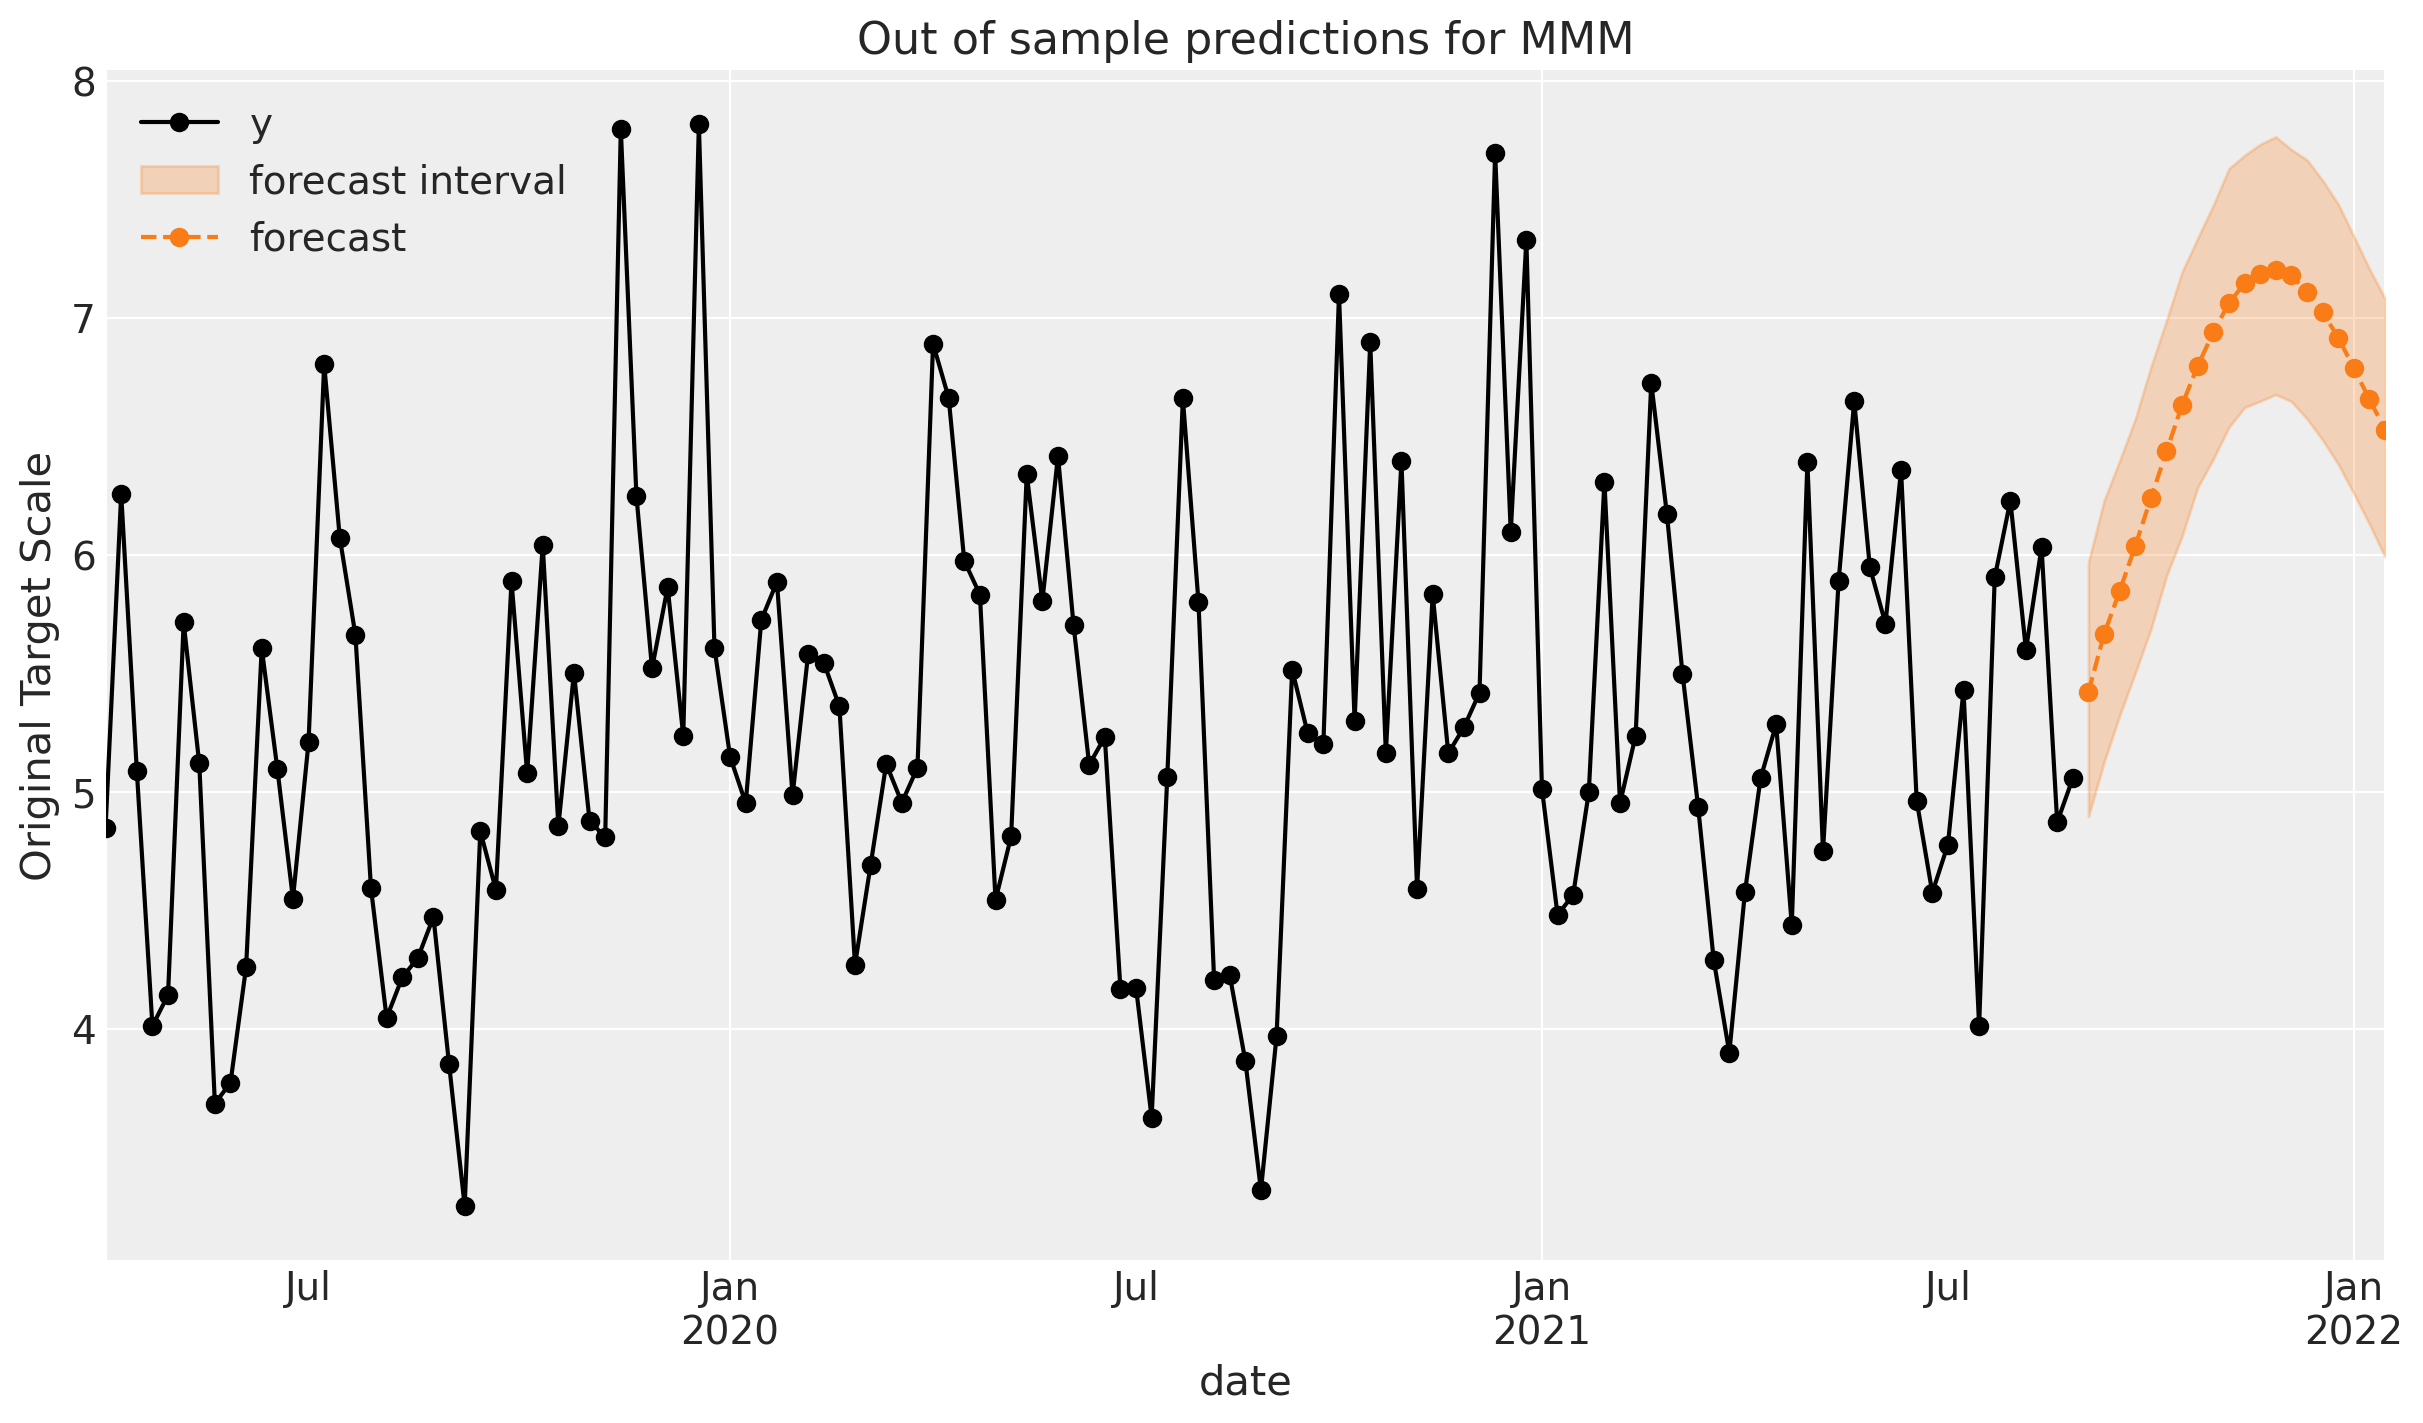

In [15]:
def plot_in_sample(X, y, ax, n_points: int = 15):
    (
        y.to_frame()
        .set_index(X["date_week"])
        # .iloc[-n_points:]
        .plot(ax=ax, marker="o", color="black", label="actuals")
    )
    return ax


def plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax, color, label):
    y_out_of_sample_groupby = y_out_of_sample["y"].to_series().groupby("date")

    lower, upper = quantiles = [0.025, 0.975]
    conf = y_out_of_sample_groupby.quantile(quantiles).unstack()
    ax.fill_between(
        X_out_of_sample["date_week"].dt.to_pydatetime(),
        conf[lower],
        conf[upper],
        alpha=0.25,
        color=color,
        label=f"{label} interval",
    )

    mean = y_out_of_sample_groupby.mean()
    mean.plot(ax=ax, marker="o", label=label, color=color, linestyle="--")
    ax.set(ylabel="Original Target Scale", title="Out of sample predictions for MMM")
    return ax


_, ax = plt.subplots()
plot_in_sample(X, y, ax=ax)
plot_out_of_sample(
    X_forecast,
    y_forecast,
    ax=ax,
    label="forecast",
    color="C1",
)
ax.legend();

The plot above shows the model's prediction for future sales (shaded region). Let's take a moment to unpack what we are seeing:

* In our forecasting scenario, we make the simplifying assumption that the future media spend (for both channels) would be at a constant level, equal to their historical averages.
* Therefore, there is no real variation in the model's prediction for future sales _from the perspective of media spend_.
* However, the model does have a trend and seasonal component, so the variation in the prediction is due to these components.

We can of course make this more realistic by considering different scenarios for future media spend, but is is a matter of refinement. What we have seen so far is the general process of using an MMM for Step 1 style forecasting.

## Level 2 - Intervention

Now we'll climb up a step and look at how we can use our MMM to predict the effect of an intervention. In this case, we will consider the effect of increasing media spend by 40% on an ongoing basis.

So let's generate the predictor variables for this intervention scenario:

In [16]:
X_intervention = pd.DataFrame(
    {
        "date_week": pd.date_range(
            start=X["date_week"].max(), periods=1 + n_new_periods, freq="W-MON"
        )[1:]
    }
).assign(
    x1=X["x1"].mean() * 2,  # double the average spend
    x2=X["x2"].mean(),  # maintain the average spend
    # other features
    t=lambda df: range(len(X), len(X) + n_new_periods),
)

X_intervention.head()

,date_week,x1,x2,t
0,2021-09-06,0.560987,0.244675,127
1,2021-09-13,0.560987,0.244675,128
2,2021-09-20,0.560987,0.244675,129
3,2021-09-27,0.560987,0.244675,130
4,2021-10-04,0.560987,0.244675,131


Now we can run the intervention and ask the MMM what it believes the effect of this intervention will be on future sales. More formally, this amounts to sampling from the posterior predictive distribution, but under the intervention scenario.

In [17]:
y_intervention = mmm.sample_posterior_predictive(
    X_pred=X_intervention, extend_idata=False, include_last_observations=True
)

Sampling: [y]


Output()

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_77783/2666701474.py:17: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  X_out_of_sample["date_week"].dt.to_pydatetime(),
/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_77783/2666701474.py:17: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  X_out_of_sample["date_week"].dt.to_pydatetime(),


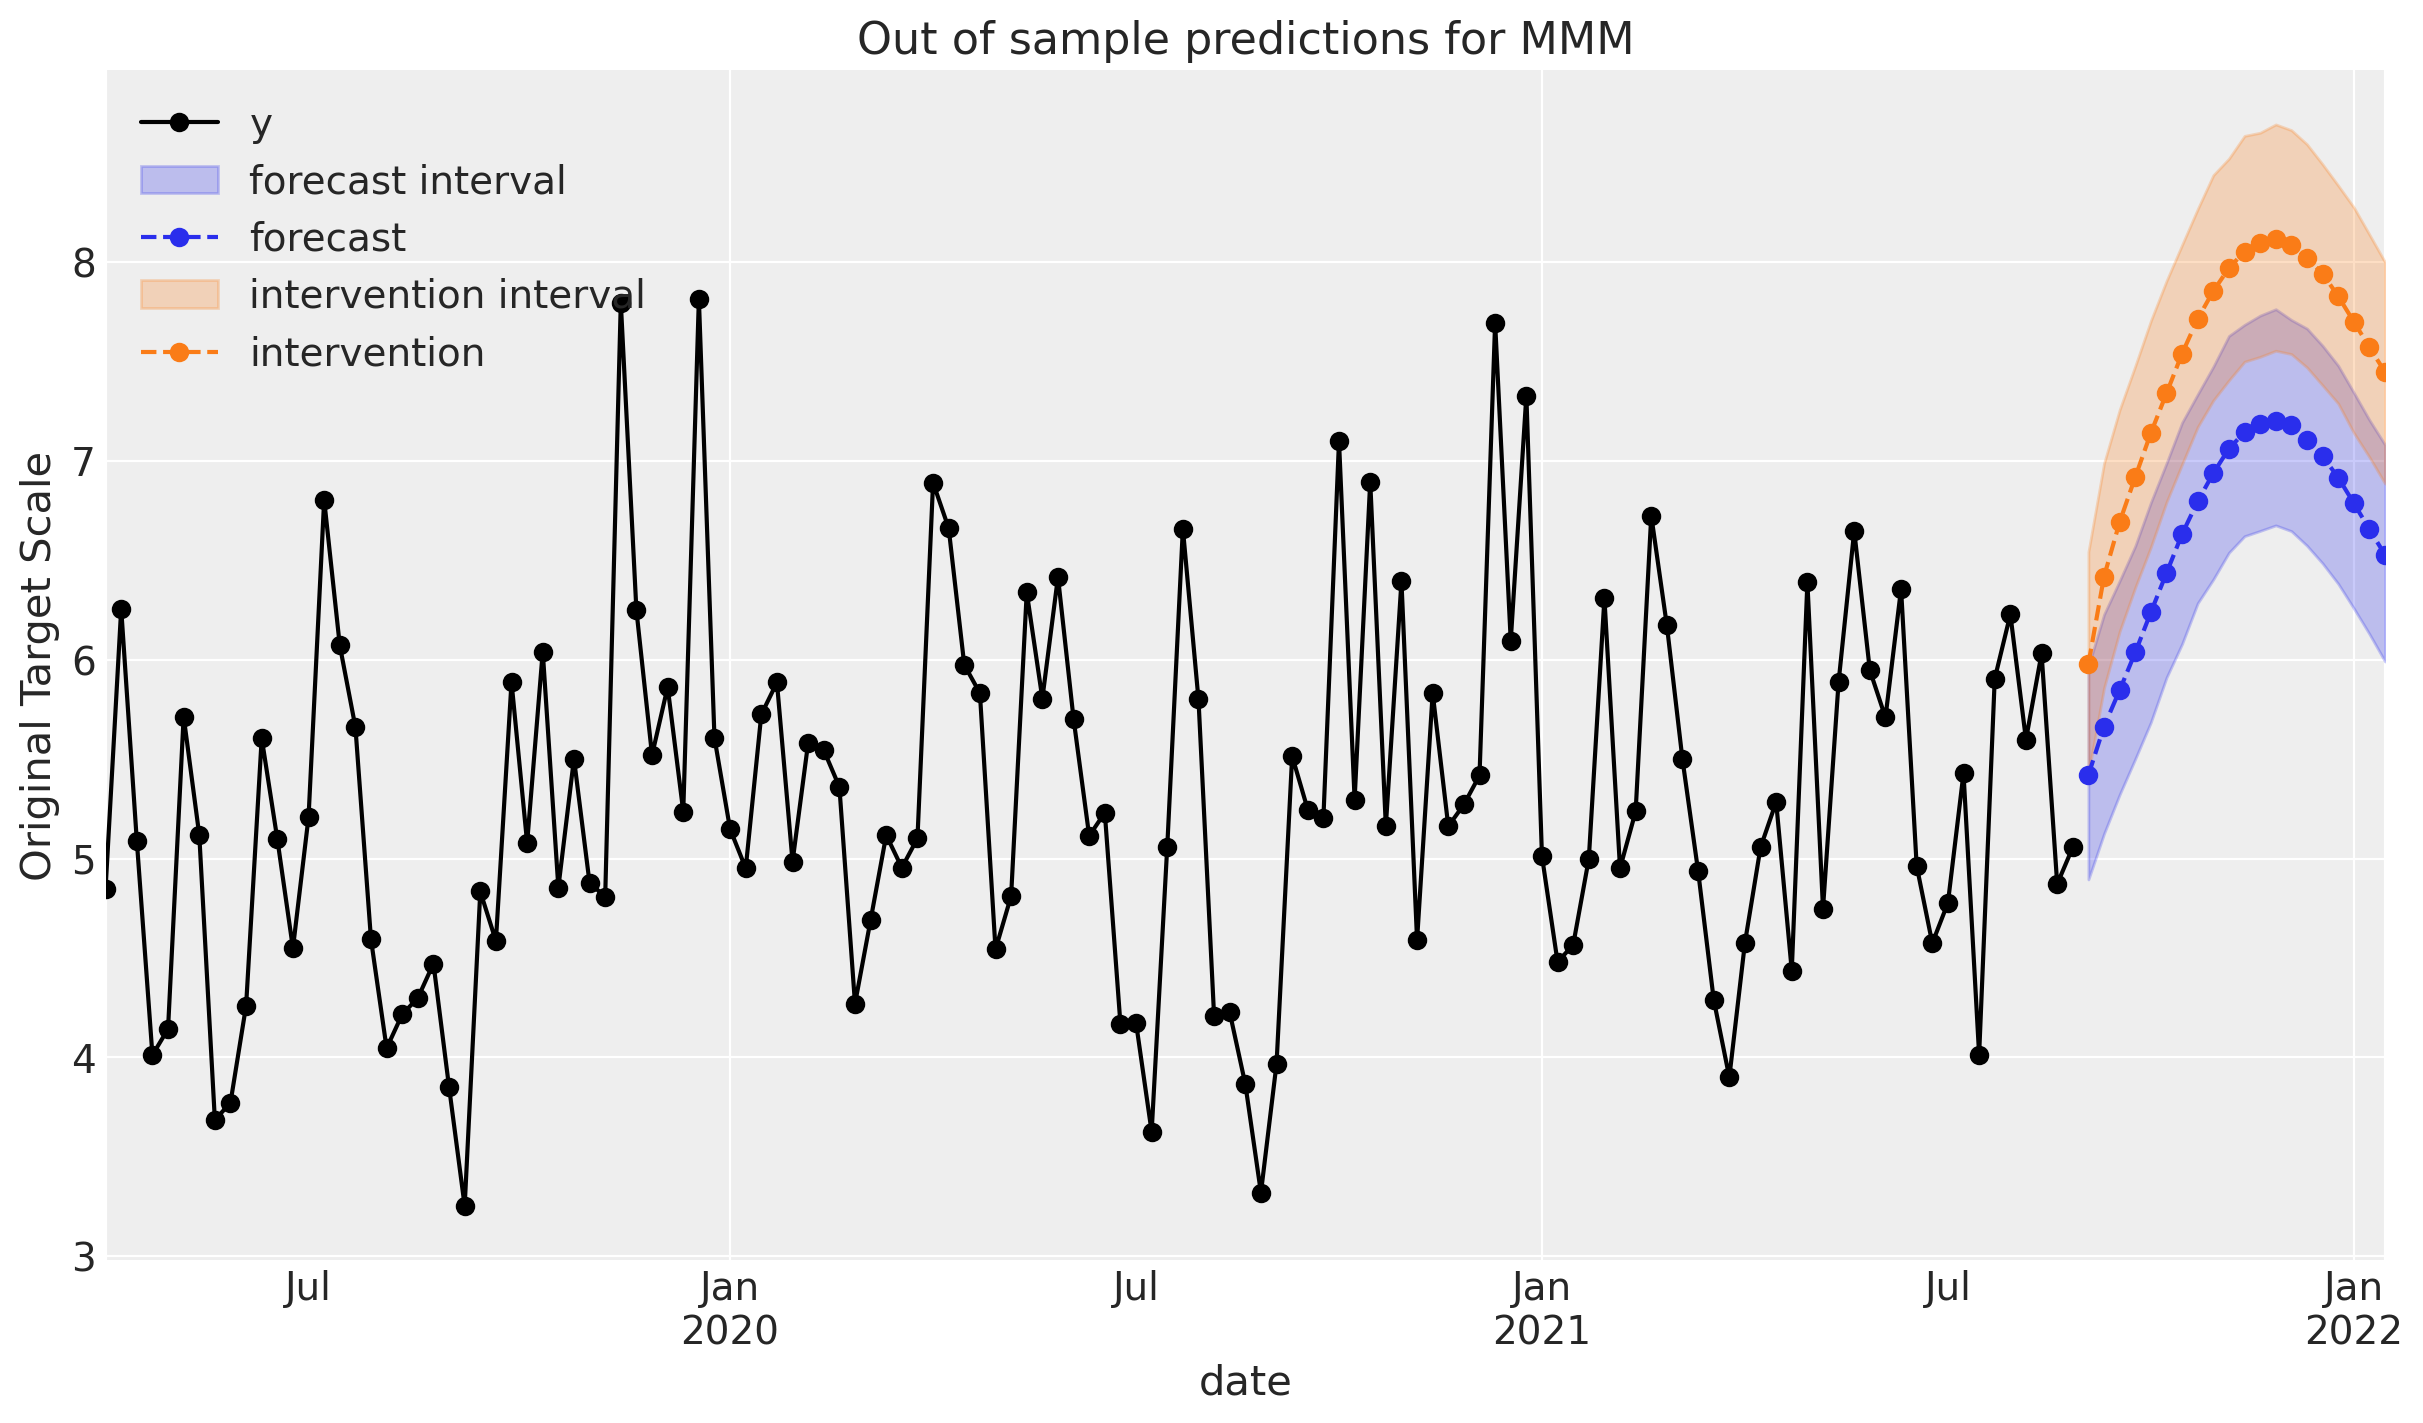

In [18]:
_, ax = plt.subplots()
plot_in_sample(X, y, ax=ax)
plot_out_of_sample(X_forecast, y_forecast, ax=ax, label="forecast", color="C0")
plot_out_of_sample(
    X_intervention,
    y_intervention,
    ax=ax,
    label="intervention",
    color="C1",
)
ax.legend();

Nice! We can see that, relative to our 'business as usual` (Step 1 forecast), the MMM predicts that the intervention will lead to an increase in sales. This is a simple example of using an MMM for causal inference - we are predicting the effect of an intervention on future sales.

:::{seealso}
For much more information on using Level 2 of the causal ladder, see the dedicated notebook on {ref}`mmm_budget_allocation_example`.
:::

## Level 3 - Counterfactual inference

Finally we are at the top of the ladder! We will now use our MMM to estimate the effect of a previous intervention. Remember, our historical dataset includes a period where we increased media spend on $x_1$ by 40%. We will use our MMM to estimate the effect of this intervention on sales.

To do this, we will compare what _actually_ happened, to what we think _would have happened_ under some alternative imagined counterfactual scenario such as not increasing media spend by 40%.

This requires coming up with a counterfactual scenario where we have to think hard about what the $x_1$ media spend would have been in the absence of the campaign. In real-world situations this might be easy or difficult, depending.

* Easy: If our marketing spend is predictable, we can simply use our business knowledge to define what the spend would have been in the absence of the campaign.
* Difficult: If our marketing spend is unpredictable, we might have to use a more sophisticated model to predict what the spend would have been in the absence of the campaign. There are ways of doing this, but it is a bit of a side-quest, so is beyond the scope of this notebook.

In our case, we will take the easy route. Because we simulated the data, we already know what our media spend would have been in the absence of the campaign. We can use this information to define our counterfactual scenario. This allows us to take a parameter recovery approach - we will be able to compare the model's counterfactual predictions to ground truth.

:::{admonition} Parameter estimation
:class: note

The logic of running through these steps on simulated actual and counterfactual data is that we can compare the MMM's ability to estimate the causal impact of the marketing campaign to the true causal impact that we know because we simulated the data. If we do ok here, we can be more confident that the MMM will be able to estimate the causal impact of the marketing campaign on real data where only the actual data is available.
:::

Let's make that more real by visualizing the `x1` and `x2` predictors, along with the `y` outcome variable. This is done for both the actual and counterfactual scenarios. We can see that there is divergence in the media spend in `x1` during the campaign period and also for the outcome variable `y`. The difference between the outcome in the actual and counterfactual scenarios is the causal effect of the marketing campaign (bottom plot).

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_77783/2418305618.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


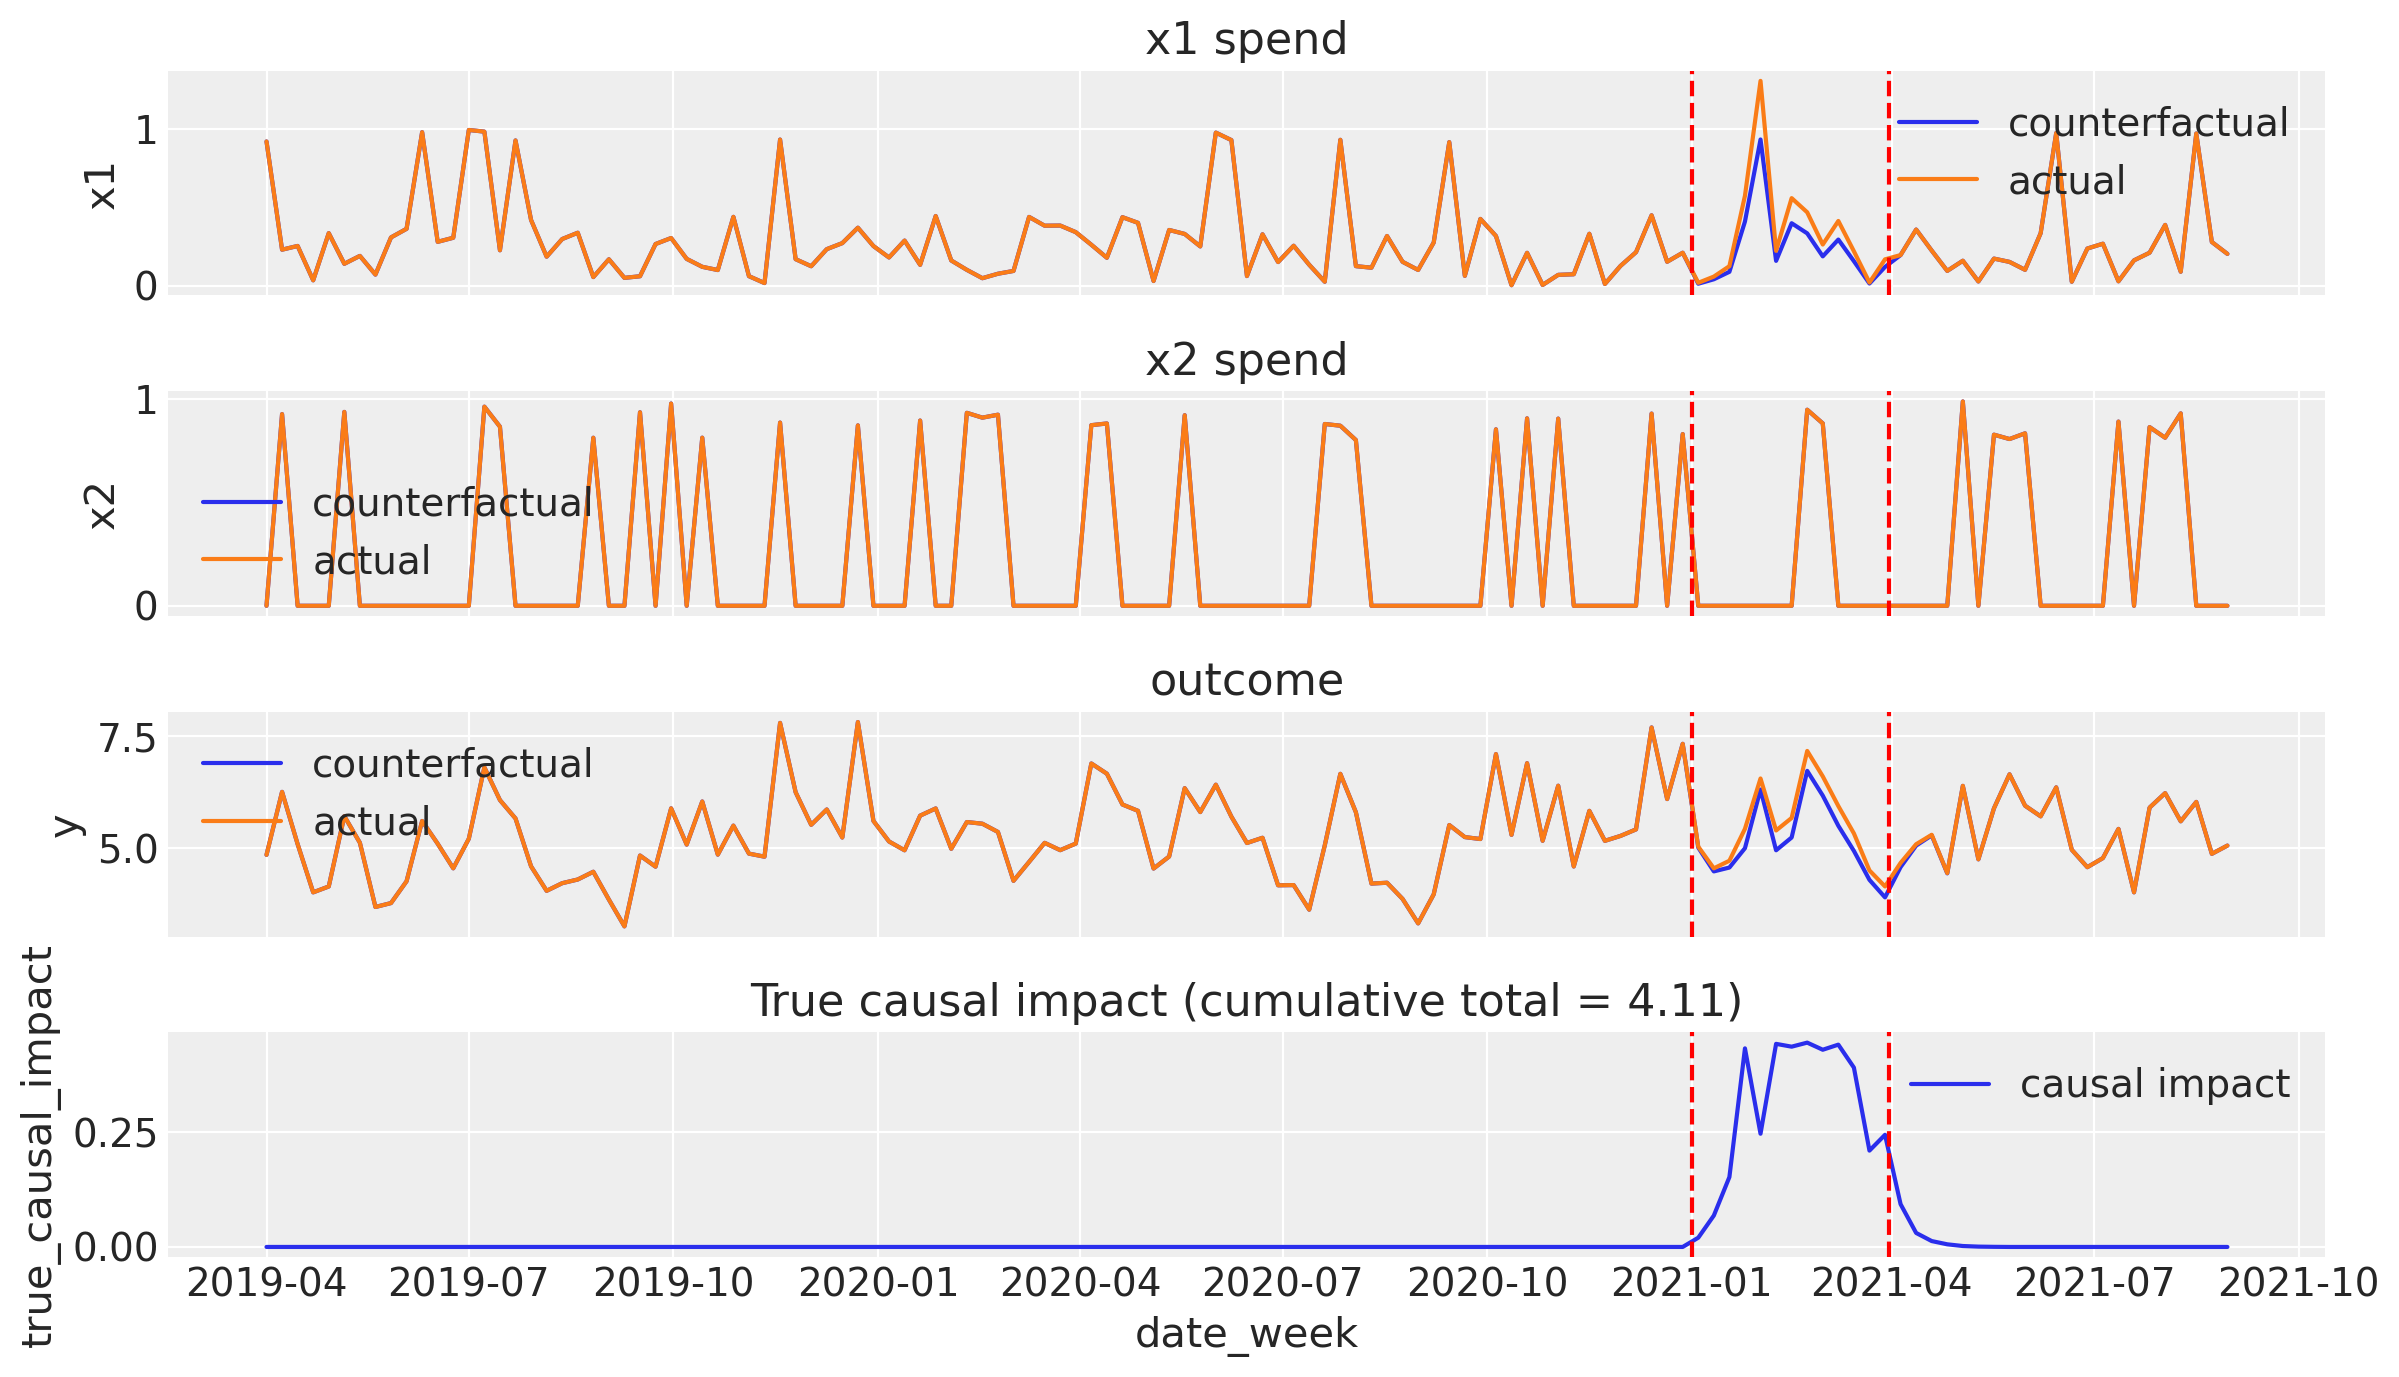

In [19]:
# calculate true causal impact
true_causal_impact: pd.DataFrame = (
    df_actual.copy()
    .assign(
        true_causal_impact=lambda x: x["y"] - df_counterfactual["y"],
        true_cumulative_causal_impact=lambda x: (
            x["y"] - df_counterfactual["y"]
        ).cumsum(),
    )
    .loc[:, ["date_week", "true_causal_impact", "true_cumulative_causal_impact"]]
)

fig, ax = plt.subplots(4, 1, sharex=True)

sns.lineplot(
    x="date_week", y="x1", data=df_counterfactual, label="counterfactual", ax=ax[0]
)
sns.lineplot(x="date_week", y="x1", data=df_actual, label="actual", ax=ax[0])
ax[0].set(title="x1 spend")

sns.lineplot(
    x="date_week", y="x2", data=df_counterfactual, label="counterfactual", ax=ax[1]
)
sns.lineplot(x="date_week", y="x2", data=df_actual, label="actual", ax=ax[1])
ax[1].set(title="x2 spend")

sns.lineplot(
    x="date_week", y="y", data=df_counterfactual, label="counterfactual", ax=ax[2]
)
sns.lineplot(x="date_week", y="y", data=df_actual, label="actual", ax=ax[2])
ax[2].set(title="outcome")

sns.lineplot(
    x="date_week",
    y="true_causal_impact",
    data=true_causal_impact,
    label="causal impact",
    ax=ax[3],
)
cumulative_impact = true_causal_impact["true_causal_impact"].sum()
ax[3].set(title=f"True causal impact (cumulative total = {cumulative_impact:.2f})")

# plot intervention point
for i in [0, 1, 2, 3]:
    plot_intervention_dates(intervention_dates, ax[i])

plt.tight_layout();

Because we are simulating this world, we know the true causal impact (bottom plot)

:::{note}
Notice in the bottom plot that the causal impact of the campaign continues on for a short duration after the campaign as ended. This is a direct result of the adstock function in the MMM which models the lagged effect of media spend on sales. Similarly, there is a slight lag effect at the start of the campaign. There is also noise in the causal impact - this makes sense because the way how we similated this data was based on changes in media spend, not on a specified level of sales difference.
:::

Now we want to evaluate what the model thinks would have happened in the counterfactual scenario that the intervention did not take place. For this, we will use the counterfactual spend in `df.x1`. But remember, in a real-world scenario, we would not have access to this data and so we would have to estimate it as discussed above.

In [20]:
X_counterfactual = df_counterfactual[["t", "date_week", "x1", "x2"]]
X_counterfactual.head()

,t,date_week,x1,x2
0,0,2019-04-01,0.918883,0.0000
1,1,2019-04-08,0.230898,0.9264
2,2,2019-04-15,0.254486,0.0000
3,3,2019-04-22,0.035995,0.0000
4,4,2019-04-29,0.336013,0.0000


The command below effectively uses the do-operator to intervene on the DAG and set `x1` to the counterfactual spend, and use the model to predict what the sales would have been in the counterfactual scenario.

In [21]:
y_counterfactual = mmm.sample_posterior_predictive(
    X_pred=X_counterfactual, extend_idata=False
);

Sampling: [y]


Output()

Now we have the actual sales data, and our predicted sales in the counterfactual scenario, we can calculate the causal impact of the intervention. This is done by comparing the actual sales to the predicted sales in the counterfactual scenario.

In [22]:
y_obs = xr.DataArray(df_actual["y"].to_numpy(), dims=["date"])
causal_impact = y_obs - y_counterfactual["y"]

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_77783/630842609.py:98: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


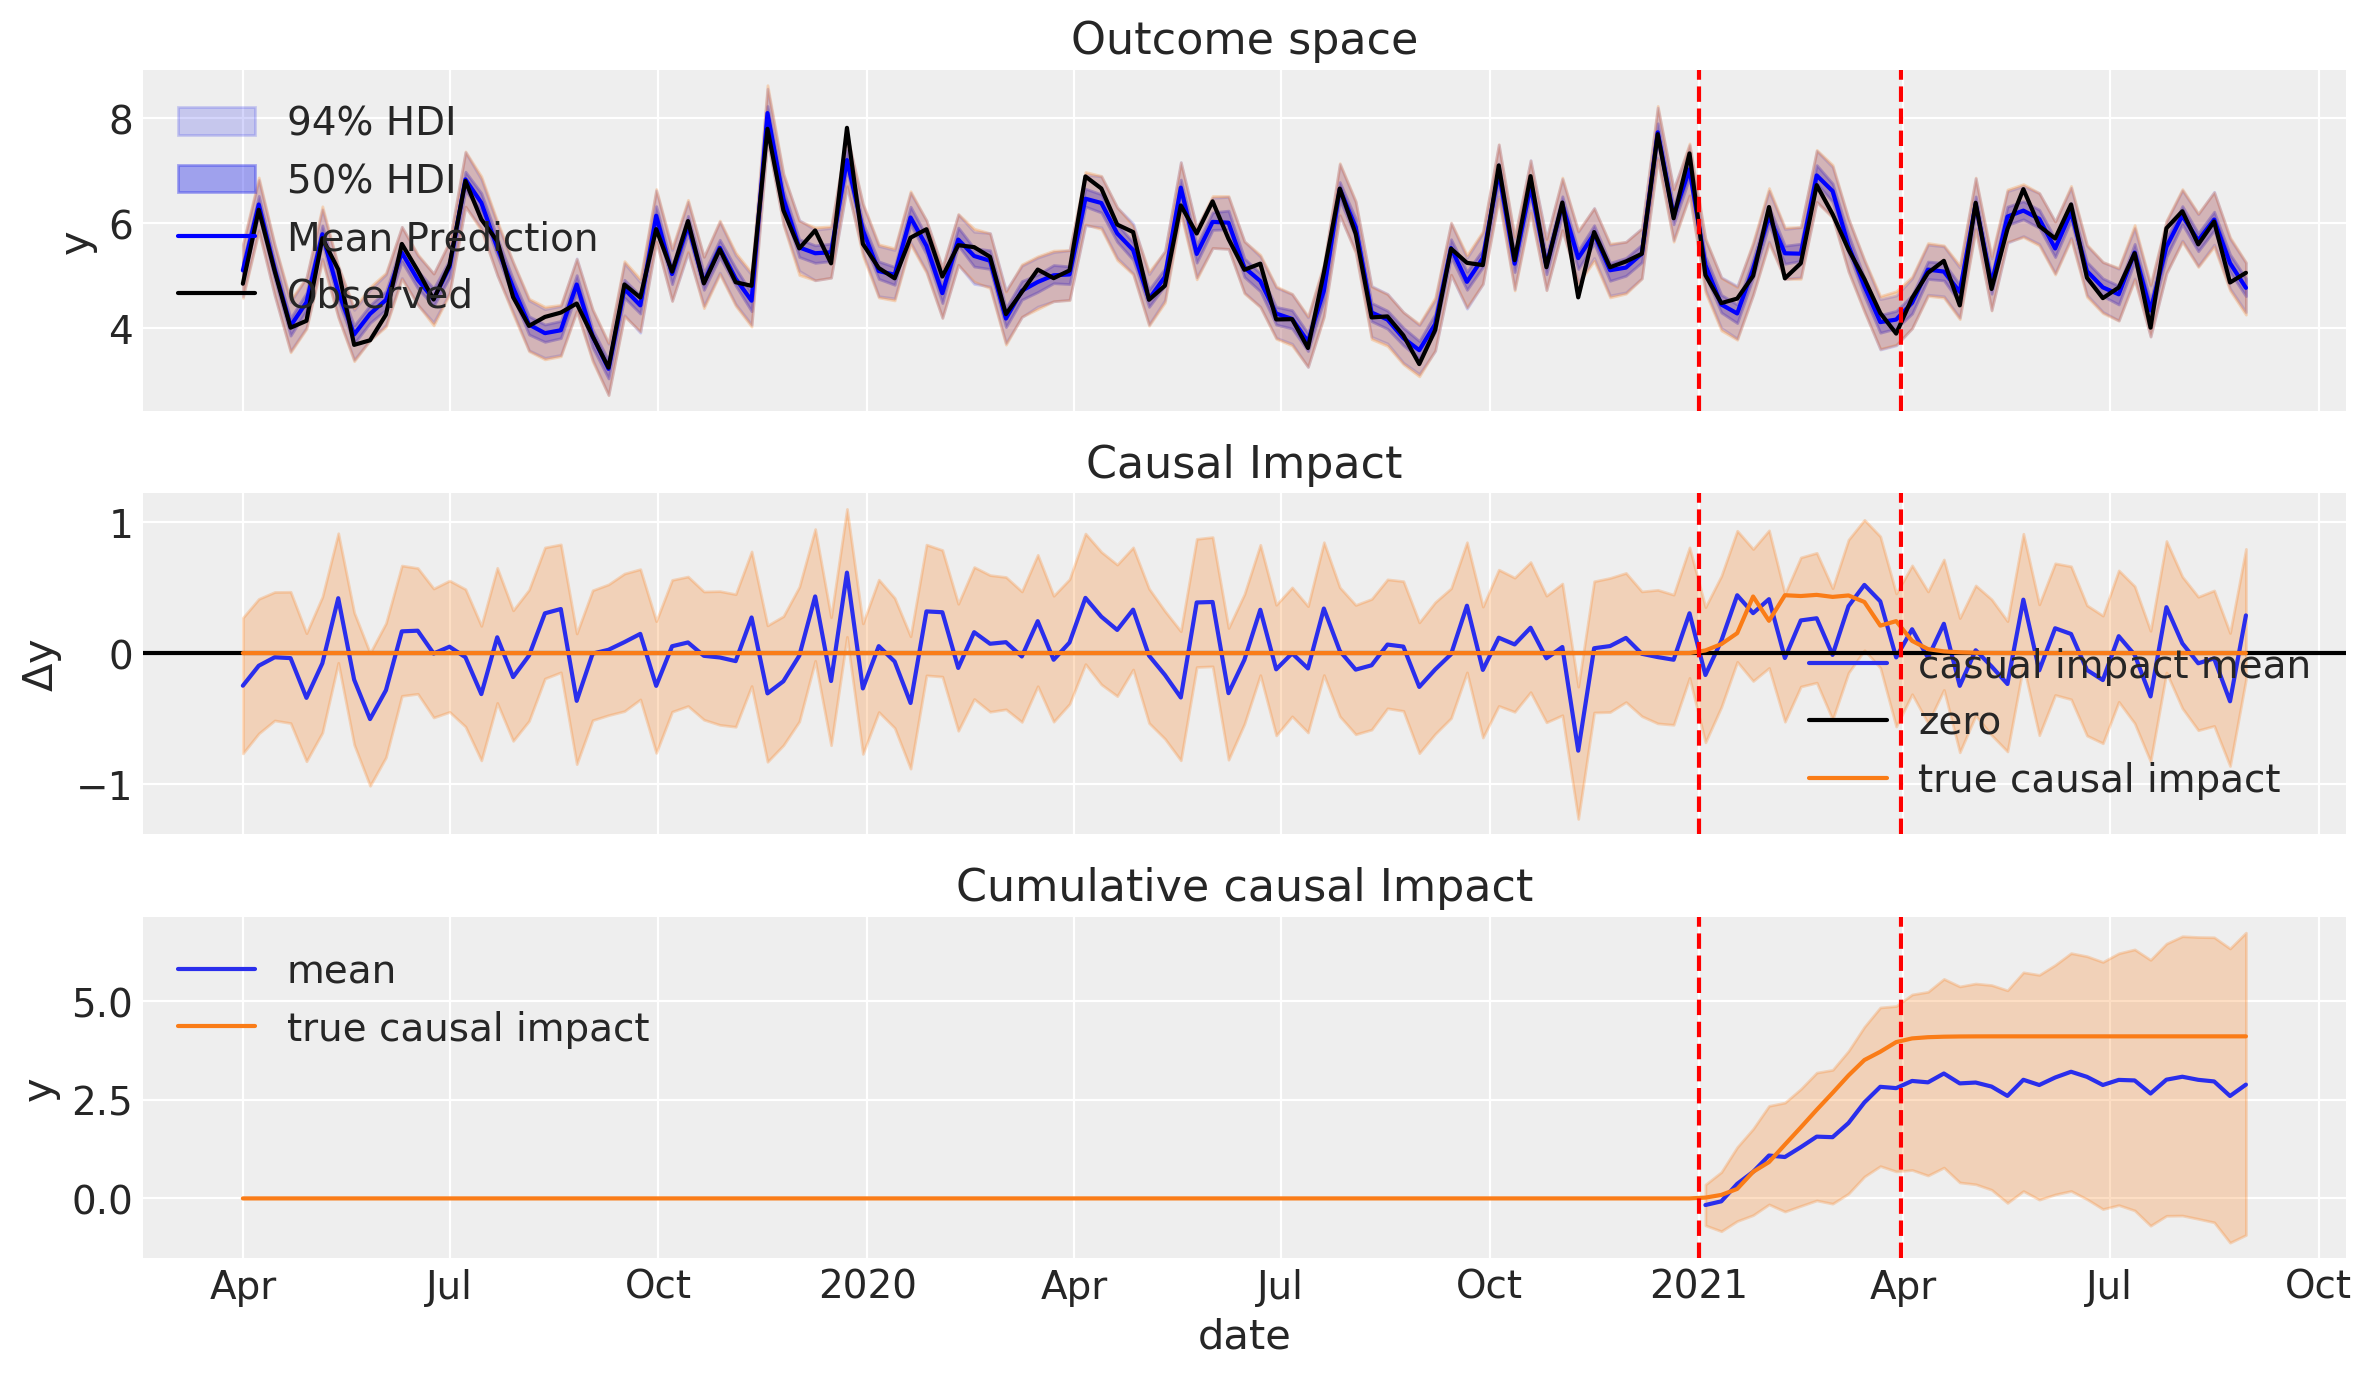

In [23]:
def plot_counterfactual_posterior_predictive(
    X_counterfactual: xr.DataArray, y_counterfactual: xr.DataArray, ax: plt.Axes
):
    y_counterfactual["y"].quantile([0.025, 0.975], dim=["sample"])
    quantiles = y_counterfactual["y"].quantile([0.025, 0.975], dim=["sample"])
    ax.fill_between(
        X_counterfactual["date_week"],
        quantiles.sel({"quantile": 0.025}),
        quantiles.sel({"quantile": 0.975}),
        alpha=0.25,
        color="C1",
    )


def plot_causal_impact(
    X_counterfactual: xr.DataArray, causal_impact: xr.DataArray, ax: plt.Axes
):
    quantiles = causal_impact.quantile([0.025, 0.975], dim=["sample"])
    ax.fill_between(
        X_counterfactual["date_week"],
        quantiles.sel({"quantile": 0.025}),
        quantiles.sel({"quantile": 0.975}),
        alpha=0.25,
        color="C1",
        # label=f"{label} interval",
    )
    # plot posterior predictive mean
    causal_impact.mean(dim="sample").plot(ax=ax, label="casual impact mean")
    ax.axhline(y=0, color="black", label="zero")
    ax.set(title="Causal Impact", xlabel="", ylabel=r"$\Delta$y")


def get_cropped_causal_impact(causal_impact: xr.DataArray, intervention_dates):
    return X_counterfactual[X_counterfactual["date_week"] >= intervention_dates[0]]


def plot_causal_impact_cumulative(
    _X_counterfactual: xr.DataArray,
    causal_impact: xr.DataArray,
    intervention_dates,
    ax: plt.Axes,
):
    _X_counterfactual = get_cropped_causal_impact(causal_impact, intervention_dates)
    # select counterfactual where date_week is greater than intervention_date
    _causal_impact = causal_impact.sel({"date": slice(intervention_dates[0], None)})
    cum_causal_impact = _causal_impact.cumsum(dim="date")
    ax.plot(
        _X_counterfactual["date_week"],
        cum_causal_impact.mean(dim="sample"),
        label="mean",
    )
    quantiles = cum_causal_impact.quantile([0.025, 0.975], dim=["sample"])
    ax.fill_between(
        _X_counterfactual["date_week"],
        quantiles.sel({"quantile": 0.025}),
        quantiles.sel({"quantile": 0.975}),
        alpha=0.25,
        color="C1",
    )
    ax.set(title="Cumulative causal Impact", xlabel="date", ylabel="y")


fig, ax = plt.subplots(3, 1, sharex=True)

# Top plot - data and predictions in outcome space
mmm.plot_posterior_predictive(original_scale=True, ax=ax[0])
plot_counterfactual_posterior_predictive(X_counterfactual, y_counterfactual, ax[0])
ax[0].set(title="Outcome space", xlabel="")

# Middle plot - causal impact
plot_causal_impact(X_counterfactual, causal_impact, ax[1])
sns.lineplot(
    x="date_week",
    y="true_causal_impact",
    data=true_causal_impact,
    label="true causal impact",
    ax=ax[1],
)
# Bottom plot - cumulative causal impact
plot_causal_impact_cumulative(
    get_cropped_causal_impact(causal_impact, intervention_dates),
    causal_impact,
    intervention_dates,
    ax[2],
)

sns.lineplot(
    x="date_week",
    y="true_cumulative_causal_impact",
    data=true_causal_impact,
    label="true causal impact",
    ax=ax[2],
)

for i in [0, 1, 2]:
    plot_intervention_dates(intervention_dates, ax[i])

plt.tight_layout();

**Top plot:** The top plot shows the actual sales data (black line), the posterior predicted sales under the actual scenario (blue shaded region), and the posterior predicted sales under the counterfactual scenario (orange shaded region). We might be able to see that the model predicts lower sales in the counterfactual scenario than in the actual scenario. This makes sense because the counterfactual scenario is one where we did not conduct the marketing campaign - so lower sales in this case would be expected.

**Middle plot:** The middle plot shows the difference between the actual and counterfactual sales. This is the causal impact of the marketing campaign. We can see that the model predicts a positive causal impact of the marketing campaign. We can also see that the model predicts negligible causal impact of the marketing capaign before the campaign started - this makes total sense but it is important to check that we don't have some unexpected causal impact before the campaign started.

**Bottom plot:** The bottom plot shows the estimated cumultive causal impact from the start of the campaign. And because we simulated the data and know the true causal impact, we can see that the model is doing a good job.

## Summary

In this notebook, we've recapped Pearl's causal ladder and seen how different levels of causal reasoning can be applied to solve business problems with MMMs. We've seen how MMMs can be used to predict future sales (Step 1), optimize marketing spend (Step 2), and evaluate the impact of marketing campaigns (Step 3).

We saw how counterfactual inference can be used to estimate the causal impact of marketing campaigns. In this notebook we used "God Mode" to simulate a world where we had knowledge of the counterfactual scenario - but in real world use cases we may have to estimate what the media spend would have been had we not run a marketing campaign.

Of course, the methods demonstrated here can be used in other ways. An immediate one that comes to mind is to evaluate the causal impact of our past media spending by comparing it to a counterfactual scenario of zero media spend (on one or multiple channels), for example.

We hope you see how this can be a powerful tool for businesses to understand the impact of their marketing efforts and make data-driven decisions.

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Mon Oct 14 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.27.0

pymc_marketing: 0.8.0
pytensor      : 2.20.0

xarray    : 2024.9.0
pandas    : 2.2.2
numpy     : 1.26.4
seaborn   : 0.13.2
matplotlib: 3.9.2
graphviz  : 0.20.1
arviz     : 0.19.0

Watermark: 2.4.3

